# MS025 Epoching
06/27/2023

In [45]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

In [46]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [47]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [48]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS025'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Preprocessed Data

In [49]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [50]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 132 x 727008 (1419.9 s), ~732.4 MB, data loaded>

In [51]:
photodiode_data

<Raw | photodiode.fif, 1 x 727008 (1419.9 s), ~5.6 MB, data loaded>

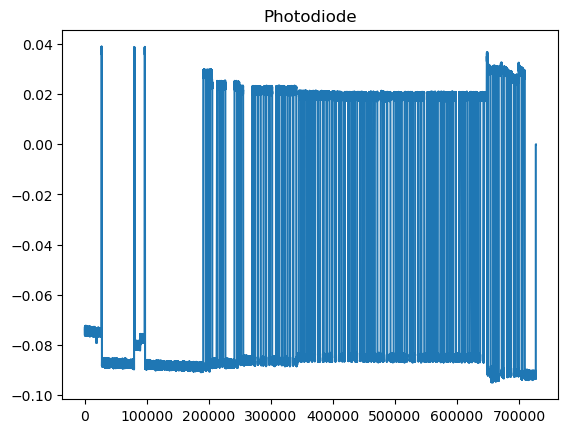

In [52]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [53]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,manual examination,notes
0,LaCaS1,A32sg_L,-8.551953,47.560752,20.574440,-7.364096,42.879442,7.816402,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus F,NaN,NaN
1,LaCaS10,Unknown,-17.348071,64.346899,55.331263,-15.943065,67.827566,42.142829,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
2,LaCaS11,Unknown,-17.747895,65.545910,58.127789,-16.252304,69.749974,44.950649,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
3,LaCaS12,Unknown,-17.747895,65.945580,59.725803,-16.193126,70.554453,46.641912,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32p_L,-9.751424,49.559103,24.968981,-8.600387,46.074869,12.332196,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L ACC,L CG,Left frontal pole 4 A,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,RPVNH9,mOccG_R,29.431284,-69.942282,-4.993797,29.084658,-86.459783,9.976051,White,Right Cerebral White Matter,Area hOc4lp,R Middle Occipital Gyrus,R LOcC,Right superior middle occipital gyrus D,NaN,NaN
168,uLAglT,rHipp_L,-16.148600,10.391424,-14.981390,-16.594453,-3.626931,-23.761121,Gray,Left Amygdala,Amygdala (LB),L ParaHippocampal Gyrus,L Hipp,Left parahippocampal gyrus A,Left amygdala inferior,NaN
169,uLmOlF,A11m_L,-8.951776,61.549208,-4.594294,-7.639574,50.840300,-25.038950,Gray,Left MOrG medial orbital gyrus,Area Fo1,L Superior Orbital Gyrus,L OrG,Left frontal orbital 2 B,NaN,NaN
170,uRAglT,rHipp_R,15.037636,10.391424,-14.182383,17.162481,-3.723941,-23.243948,Gray,Right Amygdala,Amygdala (LB),R ParaHippocampal Gyrus,R Hipp,Right amygdala inferior,NaN,NaN


## Load behavior

In [54]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,17.0,mix,281.191734,281.194518,284.000014,286.015234,2.805496,0.0,-0.80,...,-2.480351,0.073859,0.926141,-0.189300,-2.669651,-2.480351,-2.669651,-2.480351,0.000000,0.000000
1,2,132.0,loss,291.485670,291.494772,294.743755,296.760470,3.248982,-0.5,-0.91,...,-2.768263,0.648502,0.351498,2.768263,0.000000,3.323128,0.000000,0.000000,2.768263,3.323128
2,3,141.0,loss,301.272516,301.288089,303.006460,303.013385,1.718371,-0.6,-1.01,...,-3.025554,0.720153,0.279847,0.000000,-0.856332,-0.856332,0.000000,0.000000,-0.856332,-0.856332
3,4,56.0,gain,336.622560,336.630316,338.887292,338.895129,2.256976,0.2,0.00,...,0.000000,0.514178,0.485822,0.000000,0.253620,0.253620,0.000000,0.000000,0.253620,0.253620
4,5,73.0,gain,346.354041,346.354799,349.214847,351.231851,2.860048,0.4,0.00,...,0.000000,0.487715,0.512285,-0.413392,-0.413392,-0.457918,-0.413392,-0.457918,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,57.0,gain,2090.617402,2090.623172,2093.275802,2093.282839,2.652630,0.2,0.00,...,0.000000,0.523055,0.476945,0.000000,-0.083608,-0.083608,-0.083608,-0.083608,0.000000,0.000000
146,147,108.0,loss,2100.282703,2100.283575,2103.355231,2103.363451,3.071655,-0.2,-0.72,...,-2.267298,0.305133,0.694867,0.000000,-1.521720,-1.521720,-1.521720,-1.521720,0.000000,0.000000
147,148,78.0,gain,2117.280533,2117.281256,2121.776867,2121.784627,4.495610,0.4,0.00,...,0.000000,0.561598,0.438402,0.000000,0.457918,0.457918,0.000000,0.000000,0.457918,0.457918
148,149,65.0,gain,2128.339101,2128.339835,2132.104251,2134.121392,3.764415,0.3,0.00,...,0.000000,0.507858,0.492142,-0.386812,-0.386812,-0.358333,-0.386812,-0.358333,0.000000,0.000000


In [55]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [113]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=10, windSize=5, height=0.8)

17 blocks
.................

found matches for 75 of 89 pulses
8 blocks
........

found matches for 70 of 89 pulses
5 blocks
.....

found matches for 30 of 89 pulses
4 blocks
....

found matches for 20 of 89 pulses


In [114]:
print(slope,offset)

1.0729112324818488 -10.468409729433574


In [67]:
print(slope,offset)

0.9999971170386781 189.72608805556104


In [69]:
test_photo = photodiode_data

In [70]:
test_photo._data = np.abs(photodiode_data._data[0, :]-np.nanmax(photodiode_data._data[0, :])) #consider resaving photodiode 

In [92]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            test_photo, 
                                            smoothSize=3, windSize=3, height=0.8)

215 blocks
.......................................................................................................................................................................................................................

found matches for 459 of 647 pulses
80 blocks
................................................................................

found matches for 128 of 647 pulses
49 blocks
.................................................

found matches for 26 of 647 pulses
35 blocks
...................................

found matches for 72 of 647 pulses
28 blocks
............................

found matches for 46 of 647 pulses
23 blocks
.......................

found matches for 0 of 647 pulses


IndexError: index 0 is out of bounds for axis 0 with size 0

In [90]:
print(slope,offset)

1.110952019464201 -157.18754754157737


## Make epochs

In [59]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [60]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [61]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [115]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=2, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 10256 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 10428 out of 10428 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    0.2s finished


ValueError: metadata must have the same number of rows (150) as events (79)

In [17]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 0.996094 sec, baseline off, ~121.5 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 3.99609 sec, baseline off, ~202.4 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add metadata to epochs

In [18]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [19]:
epochs_all_evs[event].metadata

,rmoif2,rmoif3,rmoif4,rmoif5,rmoif6,lacas11,lacas12,racas1,racas2,racas3,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.275,1.375,0.00,1.65,0.00,0.00,2.75,1.65,0.884643,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.170,-0.170,-0.34,-0.14,-0.34,-0.14,0.00,0.00,-0.000146,-0.000159
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.250,-1.250,-2.50,-2.00,-2.50,-2.00,0.00,0.00,-0.001422,-0.000454
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.030,0.330,0.00,0.36,0.00,0.00,0.66,0.36,0.155782,0.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.30,-0.30,-0.30,-0.30,0.00,0.00,-0.000317,-0.000253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.600,0.600,0.00,0.60,0.00,0.00,1.20,0.60,-0.000616,-0.000558
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.745,-0.745,-1.49,-0.60,-1.49,-0.60,0.00,0.00,0.787978,0.558405
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.750,-0.750,-1.50,-0.30,-1.50,-0.30,0.00,0.00,0.794013,0.253269
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.950,-0.950,-1.90,-0.60,-1.90,-0.60,0.00,0.00,1.039749,0.558405


### Save epoched data

In [20]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)